<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/anomalias/src/Anomalias_palanquero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
!pip3 install windrose

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import timedelta
import matplotlib.cm as cm
from functools import reduce
from math import cos, sin, atan, pi
from windrose import WindroseAxes
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_DADOS_EVENTOS = '/dados/'
PATH_ANOMALIAS = '/anomalias/'
NOMBRE_ESTACION = 'palanquero'
FILE_DATOS_ESTACION = 'eventos_palanquero_2.csv'

LISTA_VAR = ['temp', 'hum', 'pres']
LISTA_PWV = ['pwv']
LISTA_VAR_10M = ['viento']
LISTA_PREC = ['prec']

PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'
FILES_TRATADOS = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR]
FILES_PWV = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PWV]
FILES_TRATADOS_10M = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR_10M]
FILES_TRATADOS_PREC = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PREC]

Cargando datos de Temp, Hum, Pres

In [3]:
dfList = []
for f in FILES_TRATADOS:
  df = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(df)

In [4]:
df = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
df = df.sort_values(by=['FECHA']).reset_index(drop = True)
df['HORA'] = df['FECHA'].apply(lambda x: x[11:13])

Cargando datos de Vapor de Agua

In [9]:
dfList = []
PWV_columns = []
if FILES_PWV:
    
  for f in FILES_PWV:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';', 
                  )
    dfList.append(dfp)
    PWV_columns += [col for col in dfp if col != 'FECHA']


  dfPWV = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPWV = dfPWV.sort_values(by=['FECHA']).reset_index(drop = True)

  dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PWV_columns:
    dfPWV = dfPWV.loc[~dfPWV[var].isnull()].reset_index(drop = True)

  dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPWV = pd.DataFrame(columns = ['FECHA'])

In [10]:
dfPWV

,FECHA_HORA,PWV,FECHA
0,2011-01-01 00,48.363636,2011-01-01 00:00:00-05:00
1,2011-01-01 01,48.830909,2011-01-01 01:00:00-05:00
2,2011-01-01 02,49.322727,2011-01-01 02:00:00-05:00
3,2011-01-01 03,48.856667,2011-01-01 03:00:00-05:00
4,2011-01-01 09,46.832000,2011-01-01 09:00:00-05:00
...,...,...,...
40050,2017-12-31 19,52.679091,2017-12-31 19:00:00-05:00
40051,2017-12-31 20,53.769091,2017-12-31 20:00:00-05:00
40052,2017-12-31 21,55.295455,2017-12-31 21:00:00-05:00
40053,2017-12-31 22,56.664545,2017-12-31 22:00:00-05:00


## Cargando datos de Vientos

$ \theta_p  = arctan(U_p / V_p) $ Direccíon del viento promedio

In [82]:
dfList = []
for f in FILES_TRATADOS_10M:
  dfaux = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(dfaux)

In [127]:
df10m = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)

df10m['FECHA_HORA'] = df10m['FECHA'].apply(lambda x: x[0:13])
df10m['X_VIENTO'] = df10m['VELVIENTO'] * np.sin(np.deg2rad(df10m['DIRECVIENTO'] - 180))
df10m['Y_VIENTO'] = df10m['VELVIENTO'] * np.cos(np.deg2rad(df10m['DIRECVIENTO'] - 180))

dfViento = df10m.copy()

df10m = df10m.groupby('FECHA_HORA').agg({'X_VIENTO' : 'mean', 'Y_VIENTO' : 'mean' }).reset_index()
df10m['HORA'] = df10m['FECHA_HORA'].apply(lambda x: x[11:13])
df10m['FECHA'] = pd.to_datetime(df10m['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)

In [126]:
df10m

,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,FECHA
0,2011-01-02 00,-0.020676,-0.144283,00,2011-01-02 00:00:00-05:00
1,2011-01-02 01,-0.010329,-0.114271,01,2011-01-02 01:00:00-05:00
2,2011-01-02 02,-0.004356,-0.133153,02,2011-01-02 02:00:00-05:00
3,2011-01-02 03,-0.013790,-0.164974,03,2011-01-02 03:00:00-05:00
4,2011-01-02 04,-0.002036,-0.116649,04,2011-01-02 04:00:00-05:00
...,...,...,...,...,...
41343,2017-12-31 17,0.627704,-1.636584,17,2017-12-31 17:00:00-05:00
41344,2017-12-31 19,-0.112232,0.016378,19,2017-12-31 19:00:00-05:00
41345,2017-12-31 20,-0.102170,0.407207,20,2017-12-31 20:00:00-05:00
41346,2017-12-31 21,0.194049,-0.179630,21,2017-12-31 21:00:00-05:00


## Cargando datos de precipitación

In [19]:
dfList = []
PREC_columns = []
if FILES_TRATADOS_PREC:
    
  for f in FILES_TRATADOS_PREC:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';', 
                  )
    dfList.append(dfp)
    PREC_columns += [col for col in dfp if col != 'FECHA']


  dfPrec = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPrec = dfPrec.sort_values(by=['FECHA']).reset_index(drop = True)

  # dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  # dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PREC_columns:
    dfPrec = dfPrec.loc[~dfPrec[var].isnull()].reset_index(drop = True)

  # dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPrec = pd.DataFrame(columns = ['FECHA'])



In [20]:
dfPrec

,FECHA,PREC
0,2011-01-01 00:10:00-05:00,0.0
1,2011-01-01 00:20:00-05:00,0.0
2,2011-01-01 00:30:00-05:00,0.0
3,2011-01-01 00:40:00-05:00,0.0
4,2011-01-01 00:50:00-05:00,0.0
...,...,...
278100,2017-12-31 23:10:00-05:00,0.0
278101,2017-12-31 23:20:00-05:00,0.0
278102,2017-12-31 23:30:00-05:00,0.0
278103,2017-12-31 23:40:00-05:00,0.0


## Cruzamiento de datos de Temp, hum y pres con PWV

In [21]:
dfDatos = pd.merge(df[['FECHA', 'TEMP', 'HUM', 'PRESION']], dfPWV[['FECHA', 'PWV']], on = 'FECHA', how = 'outer')
dfDatos['HORA'] = dfDatos['FECHA'].apply(lambda x: x[11:13])

dfmean = dfDatos.groupby('HORA').agg('mean').reset_index(level=0)

columns_mean = [col for col in dfmean.columns if col != 'HORA']
for col in columns_mean:
  dfmean = dfmean.rename(columns={col : f'{col}_mean'})

dfmean

,HORA,TEMP_mean,HUM_mean,PRESION_mean,PWV_mean
0,00,24.602023,93.996656,990.357252,55.670397
1,01,24.310280,94.871467,989.928955,55.334776
2,02,24.065277,95.213324,989.517105,54.783669
3,03,23.824669,95.952575,989.360551,54.348051
4,04,23.624545,95.860717,989.524463,53.916396
5,05,23.476396,96.446680,989.957486,53.633150
6,06,23.392489,96.118200,990.549096,53.486145
7,07,24.552886,94.378837,991.286165,53.349843
8,08,26.403856,86.492383,991.815086,53.023588
9,09,28.146848,79.125812,991.753458,52.845932


## Cargando Df de los eventos

In [68]:
dfEventos = pd.read_csv(PATH_DRIVE + PATH_DADOS_EVENTOS + FILE_DATOS_ESTACION, 
                 sep = ';'
                )
dfEventos = dfEventos.sort_values(by='date_min_t').reset_index(drop = True)
dfEventos['FECHA'] = pd.to_datetime(dfEventos['date_min_t'], format='%Y %m %d %H %M').dt.tz_localize('America/Bogota')
dfEventos['FECHA_MIN'] = dfEventos['FECHA'].dt.round('10min')  
dfEventos['FECHA'] = dfEventos['FECHA'].dt.round('H')
dfEventos = dfEventos[['FECHA', 'FECHA_MIN', 'min_t', 'lon_t', 'lat_t']]
dfEventos

,FECHA,FECHA_MIN,min_t,lon_t,lat_t
0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627
1,2011-04-09 23:00:00-05:00,2011-04-09 22:40:00-05:00,197.0,-74.693,5.627
2,2011-05-13 22:00:00-05:00,2011-05-13 22:20:00-05:00,187.8,-74.693,5.627
3,2011-06-06 22:00:00-05:00,2011-06-06 22:20:00-05:00,198.5,-74.693,5.484
4,2011-11-03 02:00:00-05:00,2011-11-03 02:20:00-05:00,191.9,-74.693,5.484
5,2011-11-06 03:00:00-05:00,2011-11-06 02:40:00-05:00,196.4,-74.693,5.627
6,2011-11-28 05:00:00-05:00,2011-11-28 04:40:00-05:00,227.3,-74.693,5.341
7,2011-12-11 03:00:00-05:00,2011-12-11 02:40:00-05:00,199.3,-74.693,5.484
8,2012-03-16 23:00:00-05:00,2012-03-16 22:40:00-05:00,193.6,-74.693,5.484
9,2012-03-20 23:00:00-05:00,2012-03-20 23:20:00-05:00,196.1,-74.693,5.627


# Cargando Eventos e encontrando intervalo n horas antes y después

In [125]:
funtime = lambda x, hour : [x + timedelta(hours = h) for h in (range(0, hour+1) if hour > 0 else range(hour, 0))]

# [base - datetime.timedelta(days=x) for x in range(numdays)]
dfEventAn = dfEventos.copy()
# pd.set_option('display.max_colwidth', None)

# ==================================
int_horas = 4
int_minutes = int_horas * 6 * 10
# ==================================
dfEventAn['FECHA_ANTES'] = dfEventAn['FECHA'].apply(funtime, hour = -int_horas)
dfEventAn['FECHA_DESPUES'] = dfEventAn['FECHA'].apply(funtime, hour = int_horas)
dfEventAn['FECHA_INTERVALO'] = dfEventAn['FECHA_ANTES'] + dfEventAn['FECHA_DESPUES']
dfEventAn = dfEventAn.drop(columns=['FECHA_ANTES', 'FECHA_DESPUES']).explode('FECHA_INTERVALO')
dfEventAn['FECHA_POS'] = (dfEventAn['FECHA_INTERVALO'] - dfEventAn['FECHA'])/ pd.Timedelta(hours=1)
dfEventAn = dfEventAn.rename(columns={'FECHA' : 'FECHA_EVENTO', 'FECHA_INTERVALO': 'FECHA'}).reset_index()
dfEventAn['FECHA'] = dfEventAn['FECHA'].astype(str)


dfEventAn.head(15)

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:00:00-05:00,-4.0
1,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:00:00-05:00,-3.0
2,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 21:00:00-05:00,-2.0
3,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 22:00:00-05:00,-1.0
4,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 23:00:00-05:00,0.0
5,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 00:00:00-05:00,1.0
6,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 01:00:00-05:00,2.0
7,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 02:00:00-05:00,3.0
8,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 03:00:00-05:00,4.0
9,1,2011-04-09 23:00:00-05:00,2011-04-09 22:40:00-05:00,197.0,-74.693,5.627,2011-04-09 19:00:00-05:00,-4.0


# Cruzamiento con las variables metereológicas. En terminos de 1h


In [40]:
dfCross = pd.merge(dfEventAn, dfDatos, on='FECHA', how = 'left')
dfCross['HORA'] = dfCross['FECHA'].apply(lambda x: x[11:13])
dfCross = pd.merge(dfCross, dfmean, on = 'HORA', how='left')

list_anomalias = []
for col in columns_mean:
  anomalia = f'{col}_anomalia'
  list_anomalias.append(anomalia)
  dfCross[anomalia] = dfCross[f'{col}'] - dfCross[f'{col}_mean'] 

dfAnomalia = dfCross[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()

In [ ]:
dfAnomalia

FECHA_POS TEMP_anomalia            ... PRESION_anomalia PWV_anomalia          
                      mean       std  ...              std         mean       std
0       -6.0      0.053972  1.557917  ...         1.145694     2.152636  4.395274
1       -5.0      0.108399  1.632155  ...         1.125976     2.183125  4.095265
2       -4.0      0.226235  1.320779  ...         1.224394     2.751677  3.771588
3       -3.0      0.349964  1.188915  ...         1.305966     3.256764  3.426964
4       -2.0      0.457180  1.135485  ...         1.511063     3.491419  3.138265
5       -1.0      0.393037  1.078524  ...         1.619211     3.484668  3.009741
6        0.0      0.120684  1.257764  ...         1.795704     2.735343  3.064673
7        1.0     -0.439633  1.242426  ...         1.762536     1.788008  2.997425
8        2.0     -0.531372  1.141707  ...         1.902275     1.628800  2.942431
9        3.0     -0.410947  0.987293  ...         1.845615     1.952666  3.021484
10       4.0     -0.524259  1.023989  ...         1.892017     2.064888  3.072541
11       5.0     -0.620014  1.456220  ...         1.886782     2.352379  2.969057
12       6.0     -0.558957  1.609900  ...         1.850859     2.493826  3.101611

[13 rows x 9 columns]

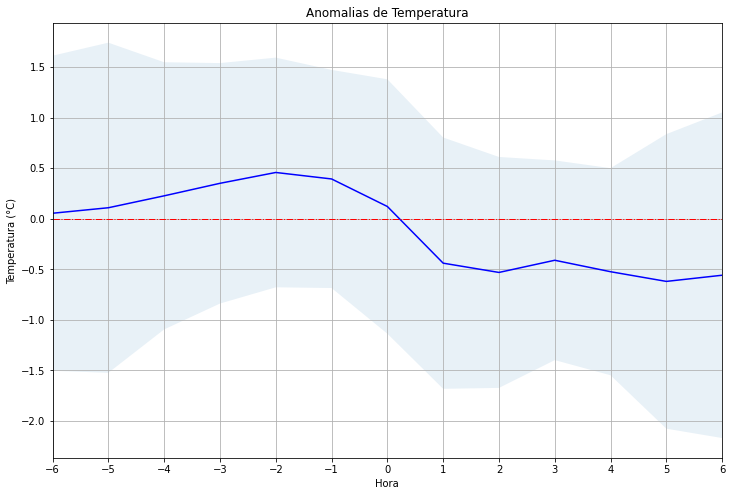

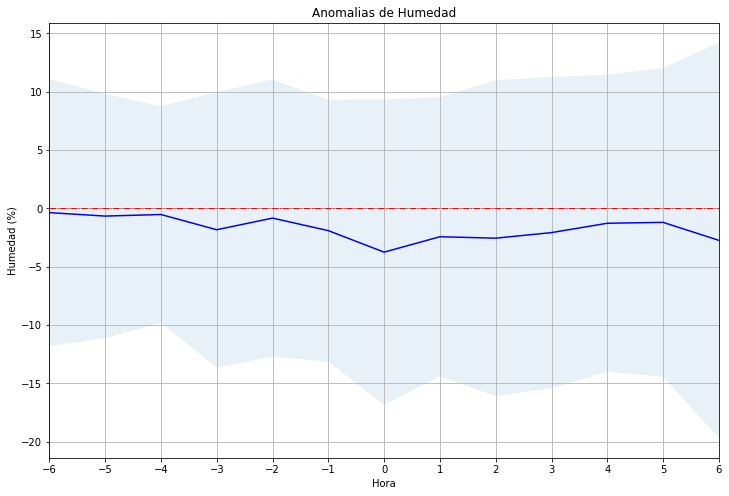

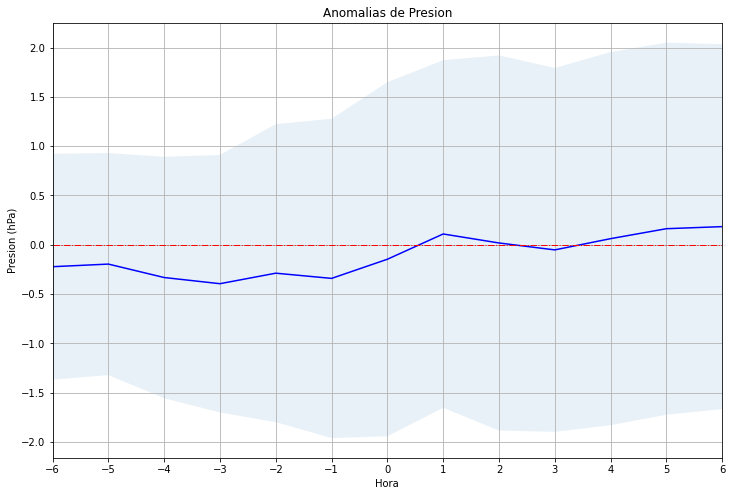

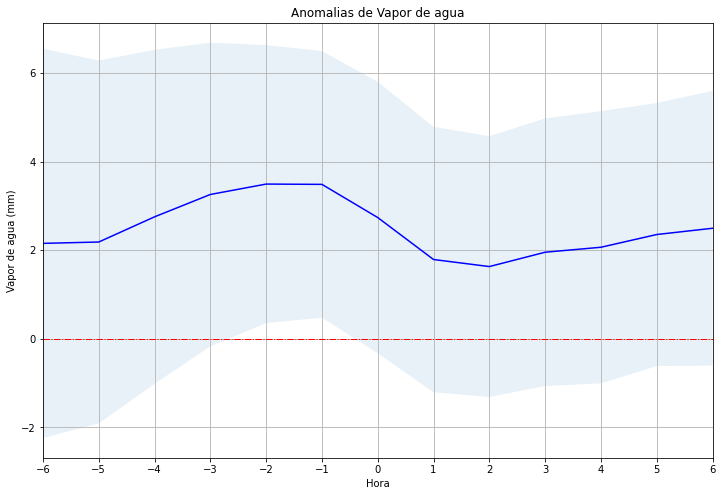

In [ ]:
def plot_anomalias(df, anomalia, titulo, name_to_save, ylabel_name, int_horas, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  plt.xticks(df['FECHA_POS'])
  plt.plot(df['FECHA_POS'], df[(anomalia, 'mean')], color = 'b')
  plt.fill_between(df['FECHA_POS'], df[(anomalia, 'mean')] + df[(anomalia, 'std')], df[(anomalia, 'mean')] - df[(anomalia, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.xlim([-int_horas, int_horas])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Hora")
  plt.ylabel(ylabel_name)
  plt.title(titulo)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Temperatura (°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Humedad (%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Presion (hPa)'},
              'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomalia, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# dfAnomalia

# Análisis con los 21 Eventos que tienen todas las variábles metereológicas completas

In [ ]:
dfEventos0 = dfCross.loc[dfCross['FECHA_POS'] == 0.]
dfEventos0 = dfEventos0[['FECHA_EVENTO', 'min_t', 'index'] + columns_mean]
dfEventos0['NUMERO_VARS'] = dfEventos0[columns_mean].notnull().sum(axis=1)
dfEventos0

,FECHA_EVENTO,min_t,index,TEMP,HUM,PRESION,PWV,NUMERO_VARS
6,2011-01-27 23:00:00-05:00,224.2,0,23.7,92.0,990.2,53.538182,4
19,2011-04-09 23:00:00-05:00,197.0,1,23.8,98.0,992.4,59.495455,4
32,2011-05-13 22:00:00-05:00,187.8,2,24.1,100.0,991.8,61.653636,4
45,2011-06-06 22:00:00-05:00,198.5,3,NaN,NaN,NaN,NaN,0
58,2011-11-03 02:00:00-05:00,191.9,4,25.6,NaN,988.4,56.503636,3
71,2011-11-06 03:00:00-05:00,196.4,5,23.7,NaN,988.9,59.640909,3
84,2011-11-28 05:00:00-05:00,227.3,6,NaN,NaN,NaN,NaN,0
97,2011-12-11 03:00:00-05:00,199.3,7,NaN,NaN,NaN,NaN,0
110,2012-03-16 23:00:00-05:00,193.6,8,NaN,NaN,NaN,NaN,0
123,2012-03-20 23:00:00-05:00,196.1,9,NaN,NaN,NaN,NaN,0


In [ ]:
dfEventos0.count()

FECHA_EVENTO    51
min_t           51
index           51
TEMP            36
HUM             26
PRESION         36
PWV             32
NUMERO_VARS     51
dtype: int64

In [ ]:
dfEventos0['NUMERO_VARS'].value_counts()

4    21
3    15
0    14
1     1
Name: NUMERO_VARS, dtype: int64

In [ ]:
dfVarsCompletas = dfEventos0.loc[dfEventos0['NUMERO_VARS'] == 4]
indexVarsCompletas = dfVarsCompletas['index']
dfVarsComp = pd.merge(dfCross, indexVarsCompletas, on = 'index', how = 'inner')

dfAnomaliaVarsComp = dfVarsComp[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()
dfAnomaliaVarsComp

FECHA_POS TEMP_anomalia            ... PRESION_anomalia PWV_anomalia          
                      mean       std  ...              std         mean       std
0       -6.0      0.306419  1.441564  ...         1.181391     1.394179  5.106512
1       -5.0      0.335481  1.858394  ...         1.068100     1.582354  4.735274
2       -4.0      0.219070  1.426882  ...         1.274862     2.083443  4.428076
3       -3.0      0.313941  1.329001  ...         1.250502     2.602140  3.969517
4       -2.0      0.277828  1.217523  ...         1.400386     2.868742  3.607619
5       -1.0      0.324550  1.136754  ...         1.531643     2.867482  3.493517
6        0.0      0.249711  1.316245  ...         1.590972     2.303907  3.536191
7        1.0     -0.401300  1.337328  ...         1.584790     1.286131  3.239916
8        2.0     -0.538283  1.121891  ...         1.755924     0.846929  2.867861
9        3.0     -0.493410  0.949121  ...         1.657401     1.129143  3.184373
10       4.0     -0.752072  0.984212  ...         1.696372     1.101938  3.227764
11       5.0     -0.862691  1.538343  ...         1.686539     1.371303  3.019227
12       6.0     -0.598337  1.839214  ...         1.770564     1.327794  2.917266

[13 rows x 9 columns]

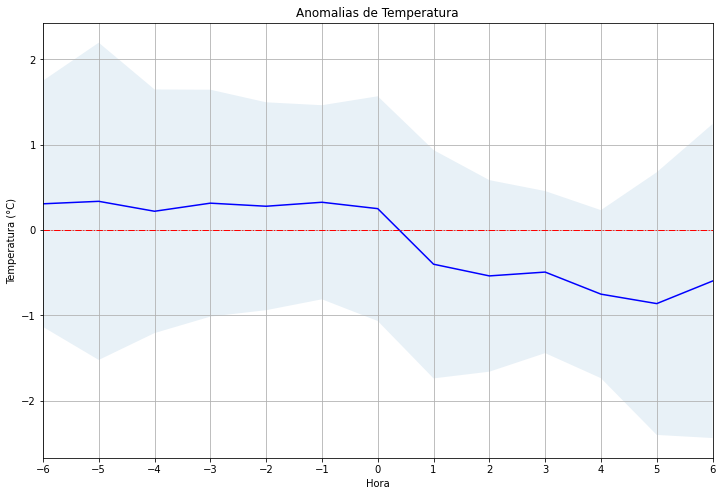

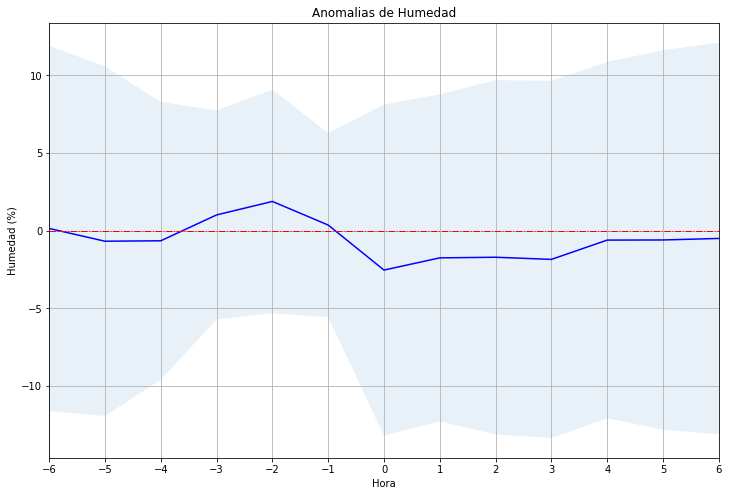

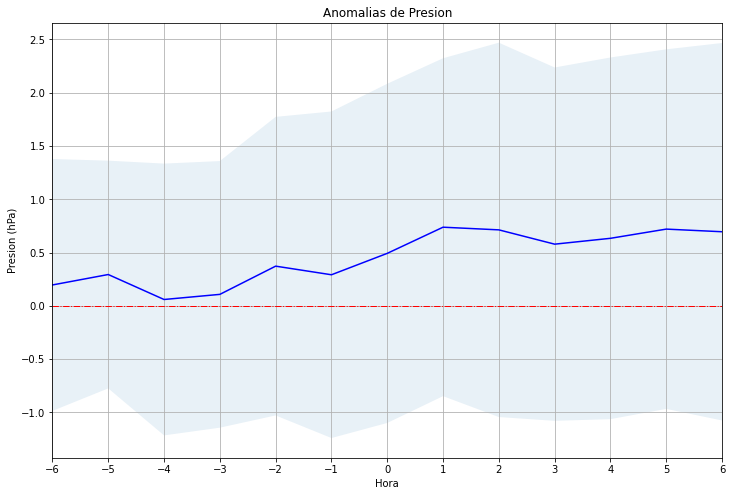

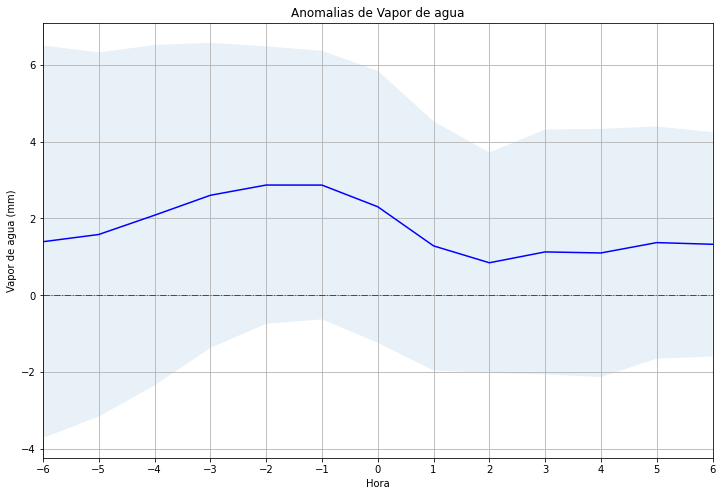

In [ ]:
dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Temperatura (°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Humedad (%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Presion (hPa)'},
              'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomaliaVarsComp, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# Análisis para Dirección del Viento 

In [70]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

# df10mean['DIRVIENTO_mean'] = df10mean.apply(func_dir, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
# df10mean['VELVIENTO_mean'] = df10mean.apply(func_vel, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
df10m['DIRVIENTO'] = df10m.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
df10m['VELVIENTO'] = df10m.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

In [71]:
df10m

,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,FECHA,DIRVIENTO,VELVIENTO
0,2011-01-02 00,0.144283,0.020676,00,2011-01-02 00:00:00-05:00,8.154988,0.145757
1,2011-01-02 01,0.114271,0.010329,01,2011-01-02 01:00:00-05:00,5.165060,0.114737
2,2011-01-02 02,0.133153,0.004356,02,2011-01-02 02:00:00-05:00,1.873571,0.133225
3,2011-01-02 03,0.164974,0.013790,03,2011-01-02 03:00:00-05:00,4.778293,0.165550
4,2011-01-02 04,0.116649,0.002036,04,2011-01-02 04:00:00-05:00,1.000000,0.116667
...,...,...,...,...,...,...,...
41343,2017-12-31 17,1.636584,-0.627704,17,2017-12-31 17:00:00-05:00,339.015918,1.752832
41344,2017-12-31 19,-0.016378,0.112232,19,2017-12-31 19:00:00-05:00,98.302416,0.113421
41345,2017-12-31 20,-0.407207,0.102170,20,2017-12-31 20:00:00-05:00,165.914990,0.419829
41346,2017-12-31 21,0.179630,-0.194049,21,2017-12-31 21:00:00-05:00,312.790163,0.264428


In [ ]:
dfCross10m = pd.merge(dfEventAn, df10m, on='FECHA', how = 'left')
dfCross10m['HORA'] = dfCross10m['FECHA'].apply(lambda x: x[11:13])
dfCross10m = pd.merge(dfCross10m, df10mean, on = 'HORA', how='left')

list_anomalias_10m = []
for col in ['X_VIENTO', 'Y_VIENTO']:
  anomalia = f'{col}_anomalia'
  list_anomalias_10m.append(anomalia)
  dfCross10m[anomalia] = dfCross10m[f'{col}'] - dfCross10m[f'{col}_mean'] 

# func_norm_360 = lambda df, x : df[x] + 360 if df[x] < 0 else df[x]
# dfCross10m['DIRVIENTO_anomalia'] = dfCross10m.apply(func_norm_360, x = 'DIRVIENTO_anomalia', axis=1)
# dfCross10m[dfCross10m['FECHA_POS'] == -6]
dfAnomalia_10m = dfCross10m[list_anomalias_10m + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()


dfAnomalia_10m['DIRVIENTO_anomalia_mean'] = dfAnomalia_10m.apply(func_dir, x = ('X_VIENTO_anomalia', 'mean'), y=('Y_VIENTO_anomalia', 'mean'), axis=1)
dfAnomalia_10m['VELVIENTO_anomalia_mean'] = dfAnomalia_10m.apply(func_vel, x = ('X_VIENTO_anomalia', 'mean'), y=('Y_VIENTO_anomalia', 'mean'), axis=1)

dfAnomalia_10m['DIRVIENTO_anomalia_std'] = dfAnomalia_10m.apply(func_dir, x = ('X_VIENTO_anomalia', 'std'), y=('Y_VIENTO_anomalia', 'std'), axis=1)
dfAnomalia_10m['VELVIENTO_anomalia_std'] = dfAnomalia_10m.apply(func_vel, x = ('X_VIENTO_anomalia', 'std'), y=('Y_VIENTO_anomalia', 'std'), axis=1)

dfAnomalia_10m

FECHA_POS X_VIENTO_anomalia  ... DIRVIENTO_anomalia_std VELVIENTO_anomalia_std
                          mean  ...                                              
0       -6.0         -0.374092  ...              39.815352               0.956379
1       -5.0         -0.118351  ...              25.384359               0.748358
2       -4.0         -0.031184  ...              26.481444               0.554505
3       -3.0         -0.115940  ...              18.195983               0.538513
4       -2.0         -0.190098  ...              20.902087               0.609293
5       -1.0          0.073063  ...              18.313143               0.906534
6        0.0         -0.203298  ...              40.743685               1.168696
7        1.0         -0.197034  ...              27.600224               0.865061
8        2.0         -0.047427  ...              26.864884               0.651530
9        3.0         -0.058915  ...              44.640145               0.550650
10       4.0          0.114283  ...              55.478779               0.499338
11       5.0          0.110734  ...              36.516624               0.734342
12       6.0          0.108628  ...              30.260764               0.555118

[13 rows x 9 columns]

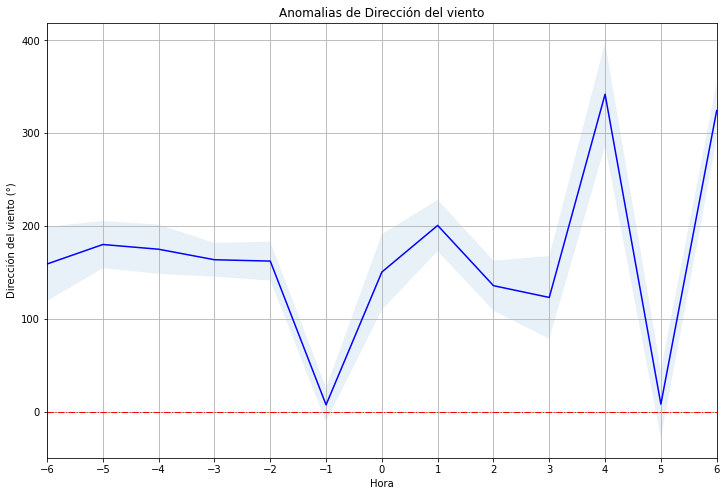

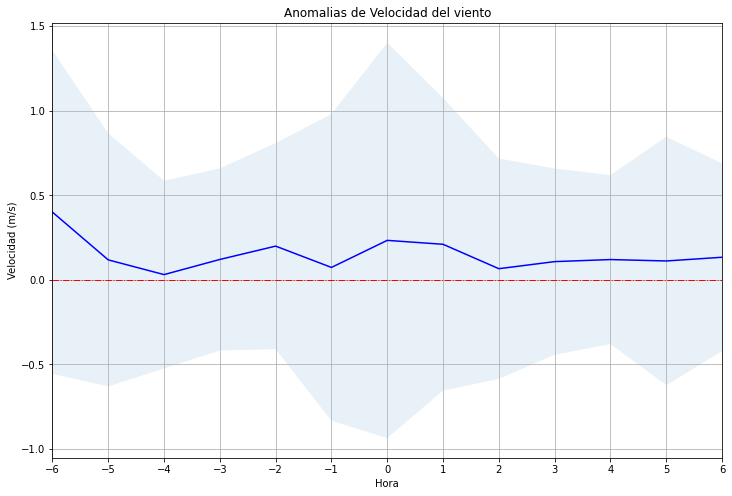

In [ ]:
def plot_anomalias_2(df, col_mean, col_std, titulo, name_to_save, ylabel_name, int_horas, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  plt.xticks(df['FECHA_POS'])
  plt.plot(df['FECHA_POS'], df[col_mean], color = 'b')
  plt.fill_between(df['FECHA_POS'], df[col_mean] + df[col_std], df[col_mean] - df[col_std], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.xlim([-int_horas, int_horas])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Hora")
  plt.ylabel(ylabel_name)
  plt.title(titulo)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/' + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'DIRVIENTO' : {'title' : 'Anomalias de Dirección del viento', 'name2save' : f'anomalias_dirviento_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Dirección del viento (°)'},
              'VELVIENTO' : {'title' : 'Anomalias de Velocidad del viento', 'name2save' : f'anomalias_velviento_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Velocidad (m/s)'},
            }

for key in dict_names:
  plot_anomalias_2(dfAnomalia_10m, f'{key}_anomalia_mean', f'{key}_anomalia_std', dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# Cargando Eventos e encontrando intervalo m minutos antes y después

In [46]:
funtimeMinutes = lambda x, minute : [x + timedelta(minutes = h) for h in (range(0, minute+1, 10) if minute > 0 else range(minute, 0, 10))]

dfEventAnMin = dfEventos.copy()

dfEventAnMin['FECHA_ANTES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = -int_minutes)
dfEventAnMin['FECHA_DESPUES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = int_minutes)

dfEventAnMin['FECHA_INTERVALO'] = dfEventAnMin['FECHA_ANTES_MIN'] + dfEventAnMin['FECHA_DESPUES_MIN']
dfEventAnMin = dfEventAnMin.drop(columns=['FECHA_ANTES_MIN', 'FECHA_DESPUES_MIN']).explode('FECHA_INTERVALO')
dfEventAnMin['FECHA_POS'] = (dfEventAnMin['FECHA_INTERVALO'] - dfEventAnMin['FECHA_MIN'])/ pd.Timedelta(minutes=1)
dfEventAnMin = dfEventAnMin.rename(columns={'FECHA_MIN' : 'FECHA_EVENTO', 'FECHA': 'FECHA_HORA', 'FECHA_INTERVALO': 'FECHA'}).reset_index(drop=True)
dfEventAnMin['FECHA'] = dfEventAnMin['FECHA'].astype(str)

dfEventAnMin.head(10)

,FECHA_HORA,FECHA_EVENTO,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 17:20:00-05:00,-360.0
1,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 17:30:00-05:00,-350.0
2,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 17:40:00-05:00,-340.0
3,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 17:50:00-05:00,-330.0
4,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 18:00:00-05:00,-320.0
5,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 18:10:00-05:00,-310.0
6,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 18:20:00-05:00,-300.0
7,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 18:30:00-05:00,-290.0
8,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 18:40:00-05:00,-280.0
9,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 18:50:00-05:00,-270.0


In [56]:
dfCrossPrec = pd.merge(dfEventAnMin, dfPrec, on='FECHA', how = 'left')

dfCrossPrecGroup = dfCrossPrec.groupby("FECHA_POS").agg({"PREC" : ["mean", "std"]})
dfCrossPrecGroup = dfCrossPrecGroup.rename(columns = {("PREC", "mean") : "PREC_mean", ("PREC", "std") : "PREC_std"}).reset_index()

dfCrossPrecGroup

FECHA_POS      PREC          
                  mean       std
0     -360.0  0.002632  0.016222
1     -350.0  0.000000  0.000000
2     -340.0  0.000000  0.000000
3     -330.0  0.002632  0.016222
4     -320.0  0.034211  0.194903
..       ...       ...       ...
68     320.0  0.218919  1.076991
69     330.0  0.094595  0.355860
70     340.0  0.043243  0.101490
71     350.0  0.035135  0.118360
72     360.0  0.043243  0.104191

[73 rows x 3 columns]

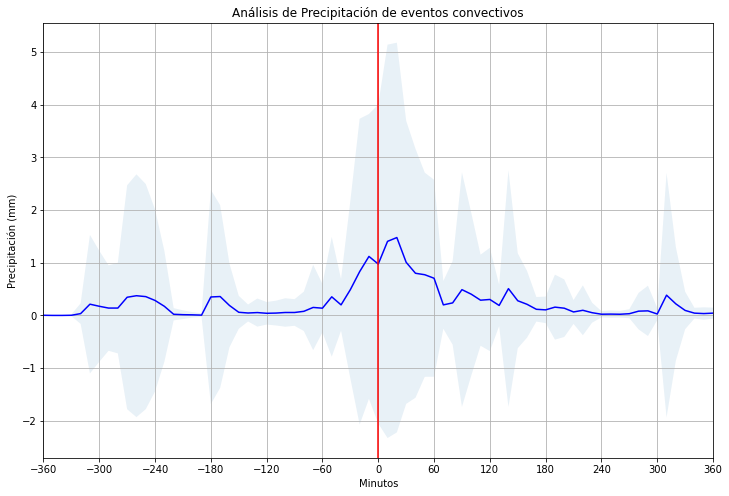

In [112]:
def plot_10m_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency])
  if has_std:
    plt.plot(df['FECHA_POS'], df[(campo, 'mean')], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[(campo, 'mean')] + df[(campo, 'std')], df[(campo, 'mean')] - df[(campo, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  # plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos")
  plt.ylabel(ylabel_name)
  plt.title(titulo)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'PREC' : {'title' : 'Análisis de Precipitación de eventos convectivos', 'name2save' : f'analisis_prec_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Precipitación (mm)'},

    }

for key in dict_names.keys():
  plot_10m_interval(dfCrossPrecGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes)


# Análisis de Viento

In [97]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

In [124]:
dfCrossVientos = pd.merge(dfEventAnMin, dfViento, on='FECHA', how = 'left')

dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"X_VIENTO" : "mean", "Y_VIENTO" : "mean"}).reset_index()
# dfCrossPrecGroup = dfCrossPrecGroup.rename(columns = {("PREC", "mean") : "PREC_mean", ("PREC", "std") : "PREC_std"}).reset_index()

dfCrossVientosGroup['DIR_VIENTO'] = dfCrossVientosGroup.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosGroup['DIR_VIENTO'] = (dfCrossVientosGroup['DIR_VIENTO'] + 180.0) % 360
dfCrossVientosGroup['VEL_VIENTO'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

dfCrossVientosGroup


,FECHA_POS,X_VIENTO,Y_VIENTO,DIR_VIENTO,VEL_VIENTO
0,-360.0,-0.078601,-0.266373,16.440228,0.277728
1,-350.0,-0.065103,-0.244007,14.939036,0.252543
2,-340.0,-0.040531,-0.092293,23.709026,0.100801
3,-330.0,-0.145534,-0.116651,51.286463,0.186514
4,-320.0,-0.143589,-0.066067,65.292111,0.158059
...,...,...,...,...,...
68,320.0,0.024851,-0.154887,350.884613,0.156868
69,330.0,0.010294,-0.149136,356.051439,0.149491
70,340.0,0.101941,-0.192083,332.044441,0.217458
71,350.0,0.152601,-0.162937,316.876014,0.223239


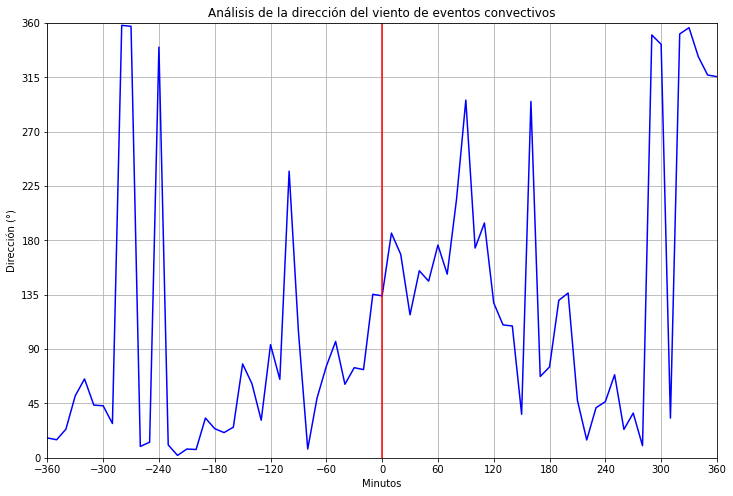

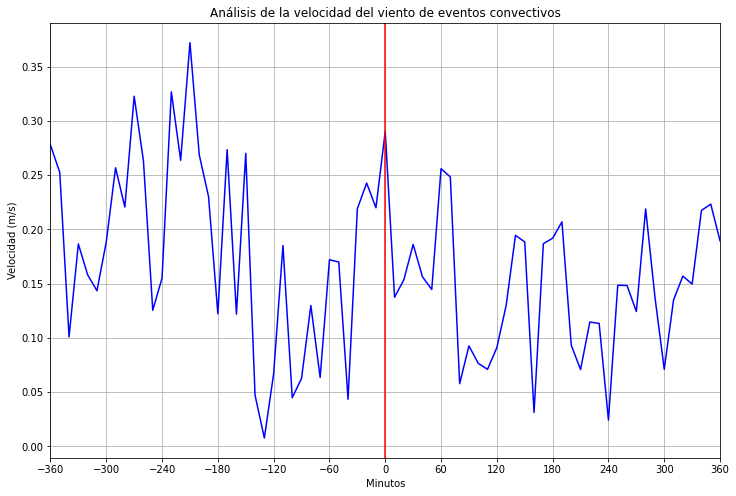

In [122]:
def plot_dir_viento_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency])
  plt.yticks(range(0, 361, 45))
  if has_std:
    plt.plot(df['FECHA_POS'], df[(campo, 'mean')], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[(campo, 'mean')] + df[(campo, 'std')], df[(campo, 'mean')] - df[(campo, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos")
  plt.ylabel(ylabel_name)
  plt.title(titulo)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'DIR_VIENTO' : {'title' : 'Análisis de la dirección del viento de eventos convectivos', 'name2save' : f'analisis_dir_viento_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Dirección (°)'},
              'VEL_VIENTO' : {'title' : 'Análisis de la velocidad del viento de eventos convectivos', 'name2save' : f'analisis_vel_viento_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Velocidad (m/s)'},
             }

key = 'DIR_VIENTO'
plot_dir_viento_interval(dfCrossVientosGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, ylimit = [0, 360], has_std=False)

key = 'VEL_VIENTO'
plot_10m_interval(dfCrossVientosGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, has_std=False)

In [136]:
df10m

,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,FECHA
0,2011-01-02 00,-0.020676,-0.144283,00,2011-01-02 00:00:00-05:00
1,2011-01-02 01,-0.010329,-0.114271,01,2011-01-02 01:00:00-05:00
2,2011-01-02 02,-0.004356,-0.133153,02,2011-01-02 02:00:00-05:00
3,2011-01-02 03,-0.013790,-0.164974,03,2011-01-02 03:00:00-05:00
4,2011-01-02 04,-0.002036,-0.116649,04,2011-01-02 04:00:00-05:00
...,...,...,...,...,...
41343,2017-12-31 17,0.627704,-1.636584,17,2017-12-31 17:00:00-05:00
41344,2017-12-31 19,-0.112232,0.016378,19,2017-12-31 19:00:00-05:00
41345,2017-12-31 20,-0.102170,0.407207,20,2017-12-31 20:00:00-05:00
41346,2017-12-31 21,0.194049,-0.179630,21,2017-12-31 21:00:00-05:00


# Análisis de viento por hora

In [138]:
dfCrossVientosHora = pd.merge(dfEventAn, df10m, on='FECHA', how = 'left')

dfCrossVientosHora
# dfCrossVientosHoraGroup = dfCrossVientosHora.groupby("FECHA_POS").agg({"X_VIENTO" : "mean", "Y_VIENTO" : "mean"}).reset_index()

dfCrossVientosHora['DIR_VIENTO'] = dfCrossVientosHora.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosHora['DIR_VIENTO'] = (dfCrossVientosHora['DIR_VIENTO'] + 180.0) % 360
dfCrossVientosHora['VEL_VIENTO'] = dfCrossVientosHora.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

dfCrossVientosHora

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,DIR_VIENTO,VEL_VIENTO
0,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:00:00-05:00,-4.0,2011-01-27 19,-0.003839,-0.139930,19,1.571393,0.139983
1,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:00:00-05:00,-3.0,2011-01-27 20,-0.005777,-0.116156,20,2.847375,0.116300
2,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 21:00:00-05:00,-2.0,2011-01-27 21,-0.035036,-0.129471,21,15.142119,0.134127
3,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 22:00:00-05:00,-1.0,2011-01-27 22,-0.031155,-0.098454,22,17.559407,0.103265
4,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 23:00:00-05:00,0.0,2011-01-27 23,-0.046361,-0.131477,23,19.423529,0.139412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 01:00:00-05:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN
455,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 02:00:00-05:00,1.0,2017-11-14 02,0.115068,-0.585969,02,348.890042,0.597161
456,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 03:00:00-05:00,2.0,2017-11-14 03,-0.239530,-0.607192,03,21.528600,0.652730
457,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 04:00:00-05:00,3.0,2017-11-14 04,-0.786721,0.552925,04,125.100419,0.961590


In [144]:
def plot_windrose(df, title, path_to_save):
  ax = WindroseAxes.from_ax()

  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, edgecolor='white', cmap=cm.cool)
  ax.set_legend(loc = 'best')
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
  plt.title(title)
  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
  plt.show()

In [142]:
posHoras = set(list(dfCrossVientosHora['FECHA_POS']))
posHoras

{-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0}

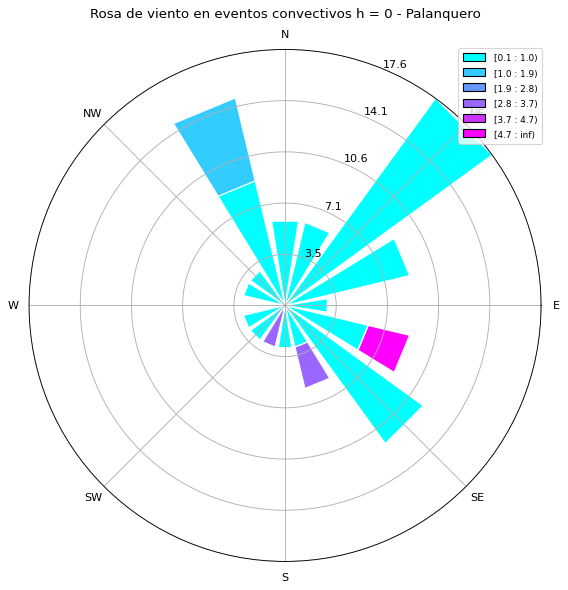

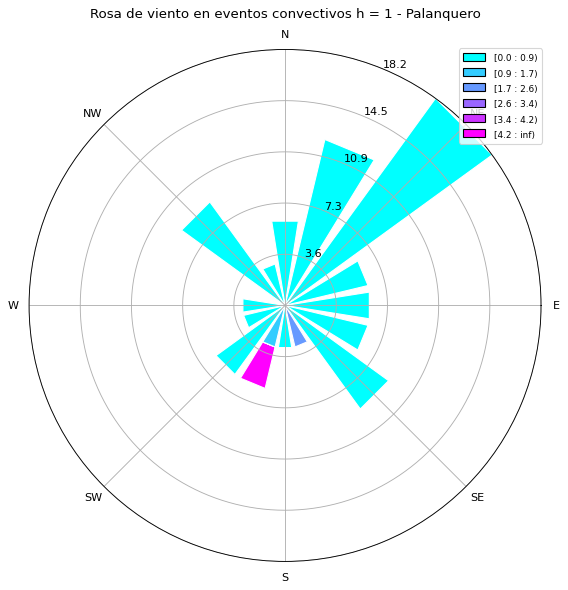

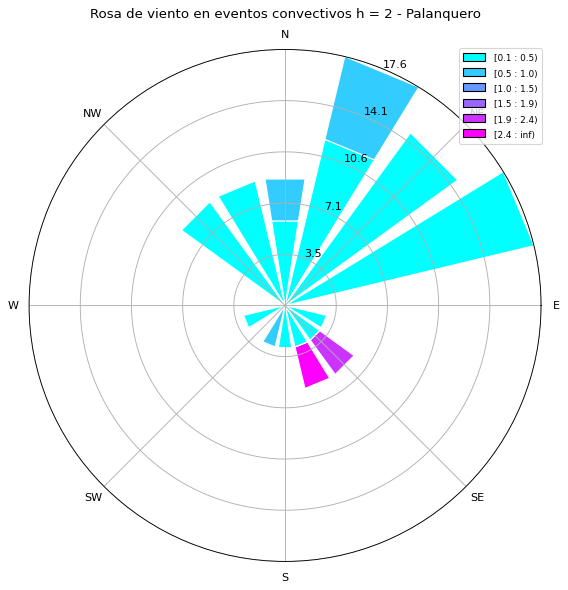

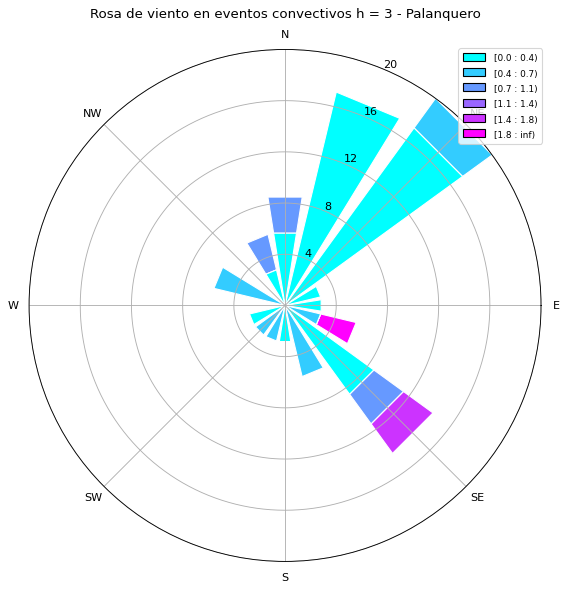

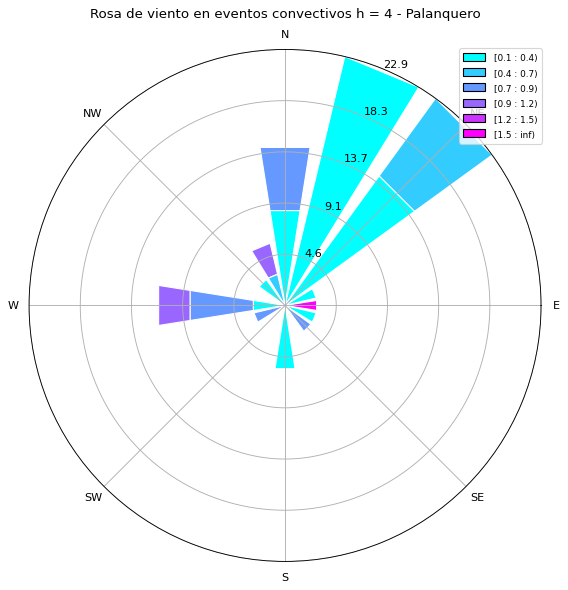

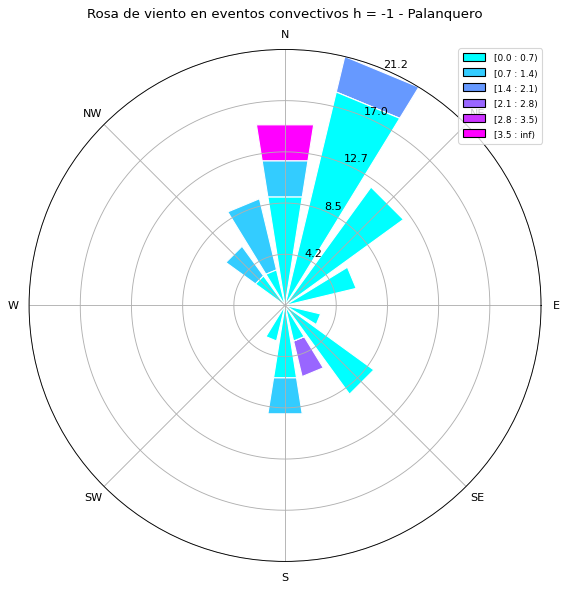

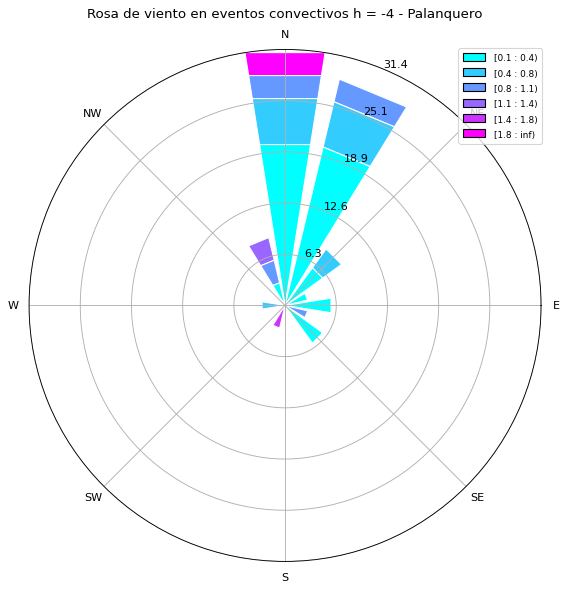

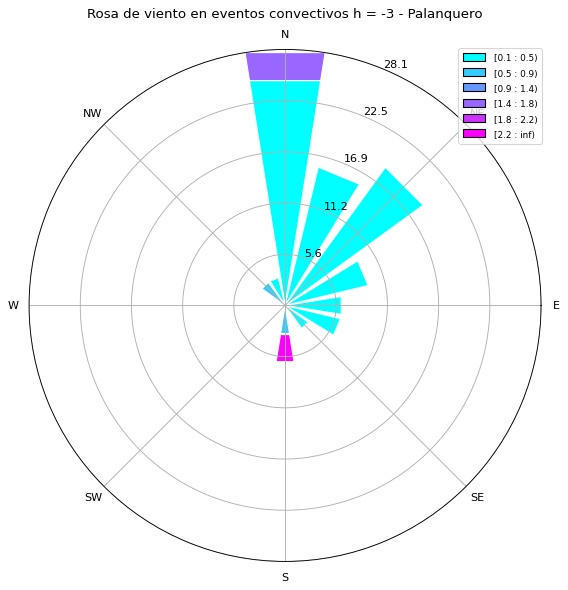

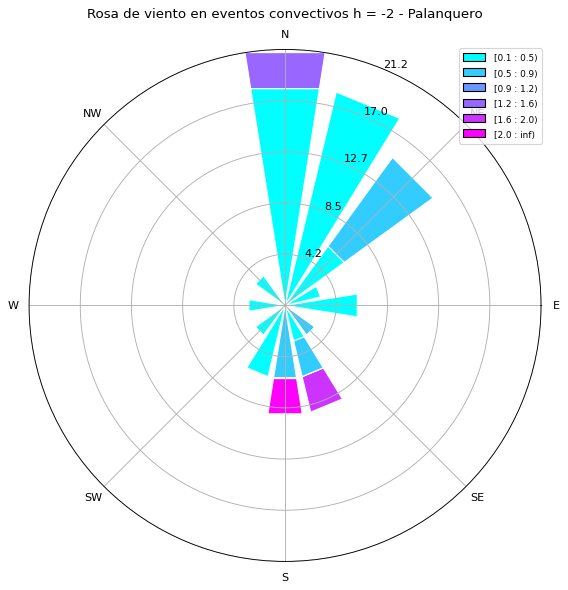

In [149]:
for hora in posHoras:
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'Rosa de viento en eventos convectivos h = {int(hora)} - {NOMBRE_ESTACION.capitalize()}'
  path_to_save = f'windrose_eventos_convectivos_hora_{int(hora)}_{NOMBRE_ESTACION.lower()}.png'
    
  plot_windrose(dft, title, path_to_save)